## Vor dem Versuch zu klärende Fragen

### Transcodierung von MP3 nach WAV und Merkmalsextraktion
In diesem Versuch wird der MP3 Decoder [mpg123](http://www.mpg123.de/) eingesetzt. Installieren und testen sie diesen Decoder vor dem Versuch auf ihrem Rechner. Machen Sie sich zunächst mit dem in Kapitel [Gegebene Module zur Transcodierung und Feature Extraction](#Gegebene-Module-zur-Transcodierung-und-Feature-Extraction) aufgeführten Code vertraut. Versuchen Sie Funktion und Ablauf dieses Programms zu verstehen und beantworten Sie folgende Fragen.

1.Was versteht man unter den statistischen Größen _Mittelwert, Standardabweichung, Skewness und Kurtosis_?

- unter dem Mittelwert versteht man den Wert, den man erhählt, wenn man alle Werte einer Stichprobe aufsummiert und diesen Wert dann durch die Anzahl der Werte teilt.
- die Standartabweichung gibt die Abweichung eines einzelnen Wertes vom Mittelwert an
- den Begriff der Skewness gibt es nur im Bezug auf asymmetrische Verteilung. Sie gibt an, wie stark die asymmetrie ist.
- Kurtosis beschreibt die "peaks" einer Verteilung and beschreibt wie stark diese um den Mittelwert sind

2.Was beschreibt die Fourier-Transformierte eines zeitlich ausgedehnten Signals?

- Sie beschreibt die Funktion, die das Spektrum beschreibt, welches durch die Fourier Transformation (zerlegte Signale) erzeugt wurde.

3.Mit welcher Samplingrate werden die WAV Dateien abgetastet?

- Die WAV Daten werden mit 10 kHz abgetastet, das bedeutet 10000 mal in der Sekunde

4.Insgesamt werden 42 Merkmale pro Musiksequenz extrahiert. Beschreiben Sie kurz diese Merkmale

- Es wird der Mittelwert, die Standardabweichung, die Kurtosis und die Skewness für meherer Blockgrößen berechnet 1, 10, 100 und 1000. Dadurch  Außerdem noch die unterschieldichen Powerwerte.

### Genetischer Algorithmus für die Merkmalsselektion

1. Beschreiben Sie die Prozesschritte im genetischen Algorithmus [Genetischer Algorithmus](https://www.hdm-stuttgart.de/~maucher/Python/FunktionenAlgorithmen/html/genAlgTSP.html)
2. In diesem Versuch wird davon ausgegangen, dass Merkmale dann gut sind, wenn durch sie die erste Teilsequenz eines Musikstücks durch einen ähnlichen Vektor wie die jeweils zweite Teilsequenz beschrieben wird. Wie kann mit dieser Annahme der genetische Algorithmus für die Merkmalsselektion angewandt werden. Unter Merkmalsselektion versteht man allgemein die Suche nach den $r$ besten Merkmalen aus einer Menge von insgesamt $R$ Merkmalen. In diesem Versuch werden initial $R=42$ Merkmale extrahiert, aus denen dann die besten $r<R$ Merkmale zu bestimmen sind. Überlegen Sie hierfür speziell wie die Fitnessfunktion, die Kreuzung und die Mutation zu realisieren sind.


1. Der Genetische Algorithmus besteht aus 5 Schritten
    1. Berechnung der Fitness: für jedes Individum wird der Fitnesswert berechnet, die Fitnessfunktion bewertet, wie 
gut eine Individum das Optimierungsziel erfüllt
    2. Selektion: Es werden zufällig 2 Individuen zum kreuzen ausgewählt, wobei die Wahrscheinlichkeit ausgewählt zu werden umso höher is je besser der Fitnesswert eines Individums ist
    3. Crossover: Zwei Individuen (A, B) werden mit einander kombiniert um 2 neue Individuen zu erzeugen. Dabei wird ein zufälliger Kreuzungspunkt im Zustandsvektor gewählt an dem dieser gesplitet wird. Es wird dann die erste Hälfte des Zustandvektors von Individum A mit der zweiten Hälfte des Zustandvektors von Individum B kombiniert. Analog funktioniert es mit dem 2. Nachkommen Individum.
    4. Mutation: Mit einer relative kleinen Wahrscheinlichkeit werden 2 Stellen im Zustandsvektor vertauscht
    5. Austausch: Die 2 Individuen mit dem schlechtesten Fitnesswert werden durch die 2 besten Induvidien, welche neu generiert wurden, ersetzt. 
    Voraussetzungen:
        - Der Zustandsvektor der Induvidien unterscheidet sich von schon existierenden Individuen
        - Die neuen Induvidien haben einen besseren Fitnesswert als die 2 schlechtesten
        

2. 
    Der Zustand ist ein Vektor mit 42 Stellen. Jede Stelle kann entweder 0 oder 1 enthalten. 
    1 Bedeutet das Merkmal wird in die Bewertung mit einbezogen. 
    0 Bedeutet das Merkmal wird nicht mit einbezogen.
    
    Eine Mögliche Erweiterung währe hier statt einfachem ein oder aus auch Zwischenwerte zuzulassen, somit könnten die Mermale unterschiedlich stark gewichtet werden.
    
    - Fitnessfunktion:
        - Es werden die selektierten Merkmale für den 1. Abschnitt und den 2. Abschnitt des Musikstücks separat berechnet. Davon berechnet man die Ähnlichkeit (z.B. Euklidische Distanz). Das Inverse davon ist dann der Fitnesswert
    - Kreuzung
        - Es wird ein zufälliger Kreuzungspunkt ausgewählt und die Vektoren an dieser Stelle gesplittet und neu kombiniert
        
        ```
            Bsp:
            a = [x1, x2, x3,   x4, x5, .... x42]
            b = [y1, y2, y3,   y4, y5, .... y42]
                             ^
                       Kreuzungspunkt  
            
            a' = [x1, x2, x3, y4, y5, .... y42]
            b' = [y1, y2, y3, x4, x5, .....x42]
        ```
        
    - Mutation
        - Zwei Stellen im Zustandsvektor werden vertauscht

### Clustering und Playlistgenerierung

1. Wie kann mit einem hierarchischen Clustering der Musikfiles eine Menge von Playlists erzeugt werden, so dass innerhalb einer Playlist möglichst ähnliche Titel zu finden sind?

# Durchführung
##Gegebene Module zur Transcodierung und Feature Extraction
Mit dem in diesem Abschnitt gegebenen Code werden die im Unterverzeichnis _BandCollection_ befindlichen mp3-Files zunächst in wave decodiert. Danach werden aus den wave Dateien Audiomerkmale erhoben.

Von jedem Musikstück werden zwei disjunkte Teilsequenzen erhoben und von beiden Teilsequenzen jeweils ein Merkmalsvektor gebildet. Der Grund hierfür ist: Für die später folgende Bestimmung der wichtigsten Merkmale (Merkmalsselektion mit dem genetischen Algorithmus), wird angenommen dass Merkmale dann gut sind, wenn die aus ihnen gebildeten Merkmalsvektoren für Teilsequenzen des gleichen Musikstücks nahe beieinander liegen und die Merkmalsvektoren von Teilsequenzen unterschiedlicher Musikstücke weiter voneinander entfernt sind. In der Merkmalsselektion werden dann die Merkmale als relevant erachtet, für die diese Annahme zutrifft. 

**Aufgaben:**

1. Stellen Sie im unten gegebenen Code die Verzeichnisse für Ihre Musikdateien (aktuell Unterverzeichnis _BandCollection_) und für den Ort Ihres _mpg123_ Decoders richtig ein.
2. Die verwendete Musiksammlung sollte mindestens 5 verschiedene Interpreten möglichst unterschiedlicher Genres enthalten. Von jedem Interpret sollten mehrere Titel (evtl. ein ganzes Album) enthalten sein.
3. Führen Sie den in diesem Abschnitt gegebenen Programmcode zur Audiofeature-Extraction aus. Damit werden für alle Musiksequenzen jeweils 42 Merkmale extrahiert. Die extrahierten Merkmalsvektoren der jeweils ersten Sequenz werden in das File _FeatureFileTrainingAllList1.csv_ geschrieben, die der zweiten Teilsequen in das File _FeatureFileTestAllList2.csv_. 


In [18]:
import subprocess
import wave
import struct
import numpy
import os
import pandas as pd

numpy.set_printoptions(precision=2,suppress=True)

#Names of features extracted in this module
FeatNames=["amp1mean","amp1std","amp1skew","amp1kurt","amp1dmean","amp1dstd","amp1dskew","amp1dkurt","amp10mean","amp10std",
           "amp10skew","amp10kurt","amp10dmean","amp10dstd","amp10dskew","amp10dkurt","amp100mean","amp100std","amp100skew",
           "amp100kurt","amp100dmean","amp100dstd","amp100dskew","amp100dkurt","amp1000mean","amp1000std","amp1000skew",
           "amp1000kurt","amp1000dmean","amp1000dstd","amp1000dskew","amp1000dkurt","power1","power2","power3","power4",
           "power5","power6","power7","power8","power9","power10"]

In [10]:
def moments(x):
    mean = x.mean()
    std = x.var()**0.5
    skewness = ((x - mean)**3).mean() / std**3
    kurtosis = ((x - mean)**4).mean() / std**4
    return [mean, std, skewness, kurtosis]

In [11]:
#Feature category 2: Frequency domain parameters
def fftfeatures(wavdata):
    f = numpy.fft.fft(wavdata)
    f = f[2:(f.size / 2 + 1)]
    f = abs(f)
    total_power = f.sum()
    f = numpy.array_split(f, 10)
    return [e.sum() / total_power for e in f]

In [12]:
#Creating the entire feature vector per music-file
def features(x):
    x = numpy.array(x)
    f = []

    xs = x
    diff = xs[1:] - xs[:-1]
    f.extend(moments(xs))
    f.extend(moments(diff))

    xs = x.reshape(-1, 10).mean(1)
    diff = xs[1:] - xs[:-1]
    f.extend(moments(xs))
    f.extend(moments(diff))

    xs = x.reshape(-1, 100).mean(1)
    diff = xs[1:] - xs[:-1]
    f.extend(moments(xs))
    f.extend(moments(diff))

    xs = x.reshape(-1, 1000).mean(1)
    diff = xs[1:] - xs[:-1]
    f.extend(moments(xs))
    f.extend(moments(diff))

    f.extend(fftfeatures(x))
    return f

In [13]:
def read_wav(wav_file):
    """Returns two chunks of sound data from wave file."""
    w = wave.open(wav_file)
    n = 60 * 10000
    if w.getnframes() < n * 3:
        raise ValueError('Wave file too short')
    #For each music file 2 sequences, each containing n frames are subtracted. The first sequence starts at postion n,
    #the second sequence starts at postion 2n. The reason for extracting 2 subsequences is, that later on we like to
    #find the best features and in this exercise we assume that good features have the property that they are similar for 2 subsequences
    #of the same song, but differ for subsequences of different songs.
    w.setpos(n)
    frames = w.readframes(n)
    wav_data1 = struct.unpack('%dh' % n, frames)
    frames = w.readframes(n)
    wav_data2 = struct.unpack('%dh' % n, frames)
    return wav_data1, wav_data2

In [30]:
def compute_chunk_features(mp3_file):
    """Return feature vectors for two chunks of an MP3 file."""
    # Extract MP3 file to a mono, 10kHz WAV file
    #mpg123_command = 'C:\Program Files (x86)\mpg123-1.22.0-x86\mpg123-1.22.0-x86\\mpg123.exe -w "%s" -r 10000 -m "%s"'
    #mpg123_command = 'C:\\Program Files (x86)\\mpg123-1.21.0-x86-64\\mpg123.exe -w "%s" -r 10000 -m "%s"'
    mpg123_command = '/usr/local/bin/mpg123 -w "%s" -r 10000 -m "%s"'
    out_file = 'temp.wav'
    cmd = mpg123_command % (out_file, mp3_file)
    temp = subprocess.call(cmd, shell=True)
    # Read in chunks of data from WAV file
    wav_data1, wav_data2 = read_wav(out_file)
    # We'll cover how the features are computed in the next section!
    return numpy.array(features(wav_data1)), numpy.array(features(wav_data2))

In [117]:
fileList=[]
featureList1=[]
featureList2=[]
#Specify the name of the directory, which contains your MP3 files here.
# This directory should contain for each band/author one subdirectory, which contains all songs of this author
for path, dirs, files in os.walk('./BandCollection'):
    #print '-'*10,dirs,files
    for f in files:
        if not f.endswith('.mp3'):
            # Skip any non-MP3 files
            continue
        mp3_file = os.path.join(path, f)
        #print mp3_file
        # Extract the track name (i.e. the file name) plus the names
        # of the two preceding directories. This will be useful
        # later for plotting.
        tail, track = os.path.split(mp3_file)
        tail, dir1 = os.path.split(tail)
        tail, dir2 = os.path.split(tail)
        # Compute features. feature_vec1 and feature_vec2 are lists of floating
        # point numbers representing the statistical features we have extracted
        # from the raw sound data.
        try:
            feature_vec1, feature_vec2 = compute_chunk_features(mp3_file)
        except:
            print "Error: Chunk Features failed"
            continue
        #title=str(track)
        title=str(dir1)+'\\'+str(track)
        print '-'*20+ title +'-'*20
        #print "       feature vector 1:",feature_vec1
        #print "       feature vector 2:",feature_vec2
        fileList.append(title)
        featureList1.append(feature_vec1)
        featureList2.append(feature_vec2)

# Write feature vecotrs of all music files to pandas data-frame
MusicFeaturesTrain=pd.DataFrame(index=fileList,data=numpy.array(featureList1),columns=FeatNames)
MusicFeaturesTrain.to_csv("FeatureFileTrainingAllList1.csv")

MusicFeaturesTest=pd.DataFrame(index=fileList,data=numpy.array(featureList2),columns=FeatNames)
MusicFeaturesTest.to_csv("FeatureFileTestAllList2.csv")

--------------------Adele\01 Hometown Glory.mp3--------------------
--------------------Adele\02 I'll Be Waiting.mp3--------------------
--------------------Adele\03 Don't You Remember.mp3--------------------
--------------------Adele\04 Turning Tables.mp3--------------------
--------------------Adele\05 Set Fire To The Rain.mp3--------------------
--------------------Adele\06 If It Hadn't Been For Love.mp3--------------------
Error: Chunk Features failed
--------------------Adele\08 Take It All.mp3--------------------
--------------------Adele\09 Rumour Has It.mp3--------------------
Error: Chunk Features failed
--------------------Adele\11 One And Only.mp3--------------------
--------------------Adele\12 Lovesong.mp3--------------------
--------------------Adele\13 Chasing Pavements.mp3--------------------
--------------------Adele\14 I Can't Make You Love Me.mp3--------------------
--------------------Adele\15 Make You Feel My Love.mp3--------------------
--------------------Adele\1

## Matching der Teilsequenzen
In diesem Abschnitt soll ein Verfahren implementiert werden, mit dem die Übereinstimmung der ersten Teilsequenz eines Musikstücks mit den zweiten Teilsequenzen aller anderen Musikstücke berechnet werden kann.

**Aufagben:**
1.Lesen Sie die im vorigen Teilversuch angelegten zwei csv-Dateien in jeweils einen eigenen Pandas Dataframe ein.

In [108]:
import pandas as pd
from sklearn.preprocessing import scale

MusicFeaturesTrain = pd.read_csv('./FeatureFileTrainingAllList1.csv')
MusicFeaturesTest = pd.read_csv('./FeatureFileTestAllList2.csv')

MusicFeaturesTrain


,Unnamed: 0,amp1mean,amp1std,amp1skew,amp1kurt,amp1dmean,amp1dstd,amp1dskew,amp1dkurt,amp10mean,...,power1,power2,power3,power4,power5,power6,power7,power8,power9,power10
0,Adele\01 Hometown Glory.mp3,-2.117173,5293.669198,0.473589,4.978067,0.002408,3030.029214,0.845604,14.037233,-2.117173,...,0.253978,0.227208,0.167310,0.116001,0.062311,0.053639,0.032771,0.028969,0.039070,0.018743
1,Adele\02 I'll Be Waiting.mp3,-4.417882,6435.340020,0.137386,3.420294,0.006315,4018.239801,0.369870,7.104337,-4.417882,...,0.289610,0.179244,0.106564,0.107570,0.084194,0.073520,0.049261,0.047791,0.039095,0.023150
2,Adele\03 Don't You Remember.mp3,-5.919595,6400.256041,0.210828,3.800593,0.006868,4127.738055,0.412036,7.174291,-5.919595,...,0.258719,0.191733,0.111335,0.110238,0.071922,0.070985,0.046546,0.066984,0.053548,0.017990
3,Adele\04 Turning Tables.mp3,-1.512502,5401.498529,0.275351,3.684370,-0.000175,3648.987956,0.530431,10.180230,-1.512502,...,0.224908,0.202309,0.128581,0.114944,0.073183,0.074391,0.045979,0.047494,0.055780,0.032430
4,Adele\05 Set Fire To The Rain.mp3,-3.252598,6159.371663,0.191136,3.522681,0.007057,3759.320952,0.498193,6.740865,-3.252598,...,0.268530,0.199045,0.109400,0.118795,0.075353,0.069513,0.043936,0.049086,0.044150,0.022191
5,Adele\06 If It Hadn't Been For Love.mp3,-0.016292,5876.079362,0.197893,3.783013,0.018505,4058.845705,0.466138,8.177568,-0.016292,...,0.252993,0.188610,0.152342,0.105496,0.072902,0.069356,0.043977,0.044031,0.044583,0.025710
6,Adele\08 Take It All.mp3,-1.461752,5056.823545,0.485544,4.649155,-0.008528,3755.674620,0.463240,14.167487,-1.461752,...,0.222507,0.204609,0.095218,0.105392,0.114318,0.087911,0.053208,0.049656,0.044997,0.022185
7,Adele\09 Rumour Has It.mp3,-1.484813,6143.370007,0.091989,3.570655,0.005213,3090.684823,0.348231,8.232116,-1.484813,...,0.348115,0.161219,0.121007,0.092032,0.065552,0.058687,0.038335,0.043973,0.040162,0.030918
8,Adele\11 One And Only.mp3,-5.509540,6422.358871,0.132365,3.588967,0.002643,3805.603341,0.549028,9.566064,-5.509540,...,0.280483,0.149154,0.134207,0.125108,0.078044,0.069512,0.048374,0.042638,0.040253,0.032227
9,Adele\12 Lovesong.mp3,-0.972877,5521.535114,0.262552,3.807431,-0.003582,2326.540259,0.737715,14.593019,-0.972877,...,0.383864,0.192071,0.100357,0.078425,0.051233,0.056267,0.033836,0.028405,0.051381,0.024161


2.Bestimmen Sie zu jeder Teilsequenz aus der Datei _FeatureFileTrainingAllList1.csv_ die euklidische Distanz zu allen Teilsequenzen aus der Datei _FeatureFileTestAllList2.csv_ und schreiben Sie diese Distanzen in eine aufsteigend geordnete Liste. Schreiben Sie auch die zugehörigen Argumente (Teilsequenzen) in eine geordnete Liste, sodass für jede Teilsequenz aus _FeatureFileTrainingAllList1.csv_ die am nächsten liegende Teilsequenz aus _FeatureFileTestAllList2.csv_ an erster Stelle steht, die zweitnächste Teilsequenz an zweiter usw.

In [4]:
from scipy.spatial.distance import euclidean

def get_euclid_dist(seq1, seq2):
    return euclidean(seq1, seq2)

In [5]:
distance_dict_euc = {}

for seq1 in MusicFeaturesTrain.iterrows():
    seq1_vector_tuple = (seq1[1].values[:1][0], seq1[1].values[1:]) 
    dist_list = []

    for seq2 in MusicFeaturesTest.iterrows():
        seq2_vector_tuple = (seq2[1].values[:1][0], seq2[1].values[1:])
        distance = get_euclid_dist(seq1_vector_tuple[1], seq2_vector_tuple[1])

        dist_list.append((seq2_vector_tuple[0], distance))

    dist_list.sort(key=lambda x: x[1])
    distance_dict_euc[seq1_vector_tuple[0]] = dist_list

distance_dict_euc.items()[:1]

[('LanaDelRey\\02 Off to the Races.mp3',
  [('LanaDelRey\\09 Carmen.mp3', 813.34927534940255),
   ('BeastieBoys\\09 Shake Your Rump.mp3', 872.52203904998248),
   ('LanaDelRey\\12 This Is What Makes Us Girls.mp3', 1700.0652957221555),
   ('LanaDelRey\\11 Summertime Sadness.mp3', 1837.4655652662279),
   ('BeastieBoys\\05 Hey Ladies.mp3', 2037.0784324595786),
   ('BeastieBoys\\15 Fight for Your Right.mp3', 2417.8443368458252),
   ('LanaDelRey\\01 Born to Die.mp3', 2673.0730706819099),
   ('BeastieBoys\\07 An Open Letter to NYC.mp3', 2711.7104348339135),
   ('LanaDelRey\\07 Dark Paradise.mp3', 2921.7992522082804),
   ("BeastieBoys\\12 Body Movin' (Fatboy Slim Remix).mp3", 2922.8690141604848),
   ('BeastieBoys\\03 Ch-Check It Out.mp3', 2923.4815779014684),
   ('Garrett\\11 Thunderstruck.mp3', 3425.6424541414185),
   ('LanaDelRey\\02 Off to the Races.mp3', 3448.7574409192007),
   ('BeastieBoys\\11 Sure Shot.mp3', 3617.8136576821439),
   ('BeastieBoys\\04 No Sleep Till Brooklyn.mp3', 3710.847

3.Bestimmen Sie über alle Teilsequenzen aus _FeatureFileTrainingAllList1.csv_ den **mittleren Rang** an dem die zugehörige zweite Teilsequenz erscheint. Liegt z.B. für die erste Teilsequenz des Musikstücks A die zweite Teilsequenz nur an fünfter Stelle der geordneten nächsten Nachbarliste. Dann würde diese Teilsequenz mit dem Rang 5 in den Mittelwert einfließen.

In [6]:
distance_vals = []

for seq1, seqs  in distance_dict_euc.items():
    for index, seq in enumerate(seqs):
        if seq[0] == seq1:
            distance_vals.append(index + 1)
            break

mean_euclid = sum(distance_vals) / len(distance_vals)

print distance_vals
print 'Mittlere Distanz: ' + str(mean_euclid)

[13, 18, 4, 18, 25, 2, 2, 1, 2, 1, 3, 1, 3, 1, 1, 18, 5, 3, 3, 1, 38, 1, 7, 7, 12, 1, 1, 9, 4, 6, 3, 1, 3, 3, 6, 1, 1, 7, 2, 1, 1, 1, 2, 1, 1, 16, 24, 1, 2, 1, 1, 4, 5, 3, 1, 5, 5, 2, 1, 5]
Mittlere Distanz: 5


4.Bestimmen Sie jetzt den mittleren Rang, für den Fall, dass _correlation_ anstelle _euclidean_ als Ähnlichkeitsmaß verwendet wird. Welches Ähnlichkeitsmaß ist für diese Anwendung zu bevorzugen?

In [7]:
from scipy.spatial.distance import correlation

def get_corr_dist(seq1, seq2):
    return correlation(seq1, seq2)

In [11]:
distance_dict_corr = {}

for seq1 in MusicFeaturesTrain.iterrows():
    seq1_vector_tuple = (seq1[1].values[:1][0], seq1[1].values[1:]) 
    dist_list = []

    for seq2 in MusicFeaturesTest.iterrows():
        seq2_vector_tuple = (seq2[1].values[:1][0], seq2[1].values[1:])
        distance = get_corr_dist(seq1_vector_tuple[1], seq2_vector_tuple[1])

        dist_list.append((seq2_vector_tuple[0], distance))

    dist_list.sort(key=lambda x: x[1])
    distance_dict_corr[seq1_vector_tuple[0]] = dist_list

distance_dict_corr.items()[:1]

[('LanaDelRey\\02 Off to the Races.mp3',
  [('RageAgainstTheMachine\\10 Freedom.mp3', 0.00068287382005072228),
   ('BeastieBoys\\09 Shake Your Rump.mp3', 0.0015679220900988167),
   ('BeastieBoys\\11 Sure Shot.mp3', 0.0016337567904449735),
   ('LanaDelRey\\09 Carmen.mp3', 0.0017190833631162139),
   ('LanaDelRey\\02 Off to the Races.mp3', 0.0021564367574465892),
   ('BeastieBoys\\06 Pass the Mic.mp3', 0.0023949335651501924),
   ('RageAgainstTheMachine\\09 Township Rebellion.mp3', 0.0024446503831492272),
   ('RageAgainstTheMachine\\08 Fistful of Steel.mp3', 0.0027919406560013016),
   ('LanaDelRey\\12 This Is What Makes Us Girls.mp3', 0.0056109240824123718),
   ("BeastieBoys\\01 So What'cha Want.mp3", 0.0060154298883517976),
   ('LanaDelRey\\11 Summertime Sadness.mp3', 0.0075670296439971363),
   ('LanaDelRey\\07 Dark Paradise.mp3', 0.0081806560512264204),
   ('BeastieBoys\\05 Hey Ladies.mp3', 0.0091777839794470184),
   ('BeastieBoys\\07 An Open Letter to NYC.mp3', 0.0097235771521931857),
 

In [9]:
distance_vals = []

for seq1, seqs  in distance_dict_corr.items():
    for index, seq in enumerate(seqs):
        if seq[0] == seq1:
            distance_vals.append(index + 1)
            break

mean_correlation = sum(distance_vals) / len(distance_vals)

print distance_vals
print 'Mittlere Distanz: ' + str(mean_correlation)

[5, 9, 1, 10, 4, 8, 3, 1, 8, 1, 1, 1, 5, 1, 2, 8, 10, 1, 3, 1, 2, 1, 18, 7, 1, 3, 1, 12, 1, 12, 3, 2, 3, 2, 1, 3, 1, 1, 3, 1, 6, 1, 9, 1, 1, 16, 2, 1, 1, 2, 1, 9, 2, 2, 2, 9, 2, 1, 1, 8]
Mittlere Distanz: 3


5.Diskutieren Sie das Ergebnis

### Auswertung:

Die correlation bietet in diesem Beispiel ein deutlich besserers Ergebnis. Wenn man die beiden Listen der einzelnen Ränge vergleicht, fällt auf, dass es bei der correlation nur sehr wenige "Ausreißer" gibt, der über den Rang 10 hinaus geht. Außerdem ist keiner der Ränge bei der correlation Distanz über 20.

Beim Euclid hingegen gibt es einige sehr große "Außreiser", die über Rang 20 hinausgehen und einer der sogar bei 38 liegt. Bei diesem Lied könnte es sein, dass die Features, die bei der ersten Sequenz extrahiert wurden, nicht wie erwartet in der zweiten Sequenz wieder auftreten.

Die correlation macht in diesem Fall mehr Sinn, da es bei Musik eher um den Zusammenhang der Noten geht. Das bedeutet, dass das Verhältnis zwischen den Werten wichtig ist und nicht nur, wie gleich die Werte sind.

Wenn die Noten in der zweiten Sequenz alle eine Oktave höher sind, stimmt bei der correlation die Distanz noch, beim Euclid dagegen wird die Distanz größer.

## Merkmalsauswahl mit dem genetischen Algorithmus
In diesem Abschnitt soll unter Anwendung eines selbst zu implementierenden genetischen Algorithmus eine Untermenge wichtiger Merkmale aus den insgesamt 42 angelegten Merkmalen berechnet werden.
Als Vorlage kann hierfür die Implementierung für die [Lösung des TSP Problems](https://www.hdm-stuttgart.de/~maucher/Python/FunktionenAlgorithmen/html/genAlgTSP.html) herangezogen werden. Anzupassen sind dann jedoch mindestens die Fitness-Funktion, die Kreuzungs- und die Mutationsfunktion. Die Fitness soll so wie im vorigen Teilabschnitt mit dem mittleren Rang berechnet werden. Die Populationsgröße, die Anzahl der auszuwählenden Merkmale und die Anzahl der Iterationen sollen als Parameter einstellbar sein.

Der Fitnesswert des besten Individuums in der Population soll in jeder Iteration gespeichert werden. Der Verlauf dieses besten Fitness-Wertes über den Fortlauf der **Iterationen soll graphisch ausgegeben** werden.

Ein Pandas Frame, der nur die berechneten **wichtigsten Merkmale aus _FeatureFileTrainingAllList1.csv_ enthält soll angelegt und in die csv Datei _subFeaturesTrain1.csv_ geschrieben** werden.

**Aufgaben:**
1. Implementieren Sie die die Merkmalsauswahl mit dem genetischen Algorithmus entsprechend der o.g. Beschreibung
2. Beschreiben Sie kurz das Konzept ihrer Kreuzungs- und Mutationsfunktion. 
3. Bestimmen Sie eine möglichst kleine Merkmalsuntermenge mit einem möglichst guten mittleren Rang? Geben Sie sowohl die gefundenen wichtigsten Merkmale als auch den zugehörigen mittleren Rang an.
4. Um wieviel verschlechtert sich der Mittlere Rang, wenn nur die 10 wichtigsten Merkmale benutzt werden?

In [98]:
def calculate_cost(imp_feature_vec):
    distance_dict_corr = {}

    for seq1 in MusicFeaturesTrain.iterrows():
        seq1_vector_tuple = (seq1[1].values[:1][0], get_modified_features(seq1[1].values[1:], imp_feature_vec)) 
        dist_list = []

        for seq2 in MusicFeaturesTest.iterrows():
            seq2_vector_tuple = (seq2[1].values[:1][0], get_modified_features(seq2[1].values[1:], imp_feature_vec))
            distance = get_corr_dist(seq1_vector_tuple[1], seq2_vector_tuple[1])

            dist_list.append((seq2_vector_tuple[0], distance))

        dist_list.sort(key=lambda x: x[1])
        distance_dict_corr[seq1_vector_tuple[0]] = dist_list

    distance_vals = []

    for seq1, seqs  in distance_dict_corr.items():
        for index, seq in enumerate(seqs):
            if seq[0] == seq1:
                distance_vals.append(index + 1)
                break

    mean_correlation = sum(distance_vals) / len(distance_vals)
    
    return mean_correlation
    

In [99]:
def get_modified_features(feature_vec, imp_feature_vec):
    new_feature_vec = []
    for index, feature in enumerate(feature_vec):
        new_feature_vec.append(feature * imp_feature_vec[index])
    return new_feature_vec
        

In [100]:
middle_range_test = calculate_cost([0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1])
print 'Middle range for this vector is: %i' % (middle_range_test)

Middle range for this vector is: 5


#### Genetischer Algorithmus für die Music Feature Selection

In [104]:
# -*- coding:utf-8 -*-
import numpy as np
from scipy.spatial.distance import pdist,squareform

np.random.seed()
    
###########################################################################
#              Genetischer Algorithmus zur Lösung des TSP                 #
###########################################################################

ITERATIONS=5;
POPULATION_SIZE=4;
CROSSPROP=0.99;
MUTPROP=0.05;
NUMBER_OF_FEATURES=42

iteration = 0;

#In diesem Array wird für jede Iteration die beste Distanz gespeichert
bestDist=np.zeros(ITERATIONS) 


#Erzeugen einer zufälligen Startpopulation
population= np.array([ np.random.randint(2, size=NUMBER_OF_FEATURES) for i in range(POPULATION_SIZE) ])

cost=np.zeros(POPULATION_SIZE)

for iteration in range(ITERATIONS):

    for (i, pop) in enumerate(population):
        cost[i]=calculate_cost(pop)

    sortedIndex=cost.argsort(axis=0)#Indizees der nach ansteigenden Kosten sortierten Chromosomen
    sortedCost=cost[sortedIndex] #die ansteigend sortierten Kosten
    bestDist[iteration]=sortedCost[0]

    sortedPopulation=population[sortedIndex] #Sortierung der Population nach ansteigenden Kosten
    InvertedCost=1/(sortedCost + 0.001) #Berechung des Nutzen (Fitness) aus den Kosten
    #InvertedCost enthält die berechneten Fitness-Werte


    # 2.Selektion: Zufällige Auswahl von Chromosomen aus der Population####################
    # Mit dem folgenden Prozess wird gewährleistet, dass die Wahrscheinlichkeit für die
    # Selektion eines Chromosoms umso größer ist, je größer sein Nutzenwert ist.
    InvertedCostSum = InvertedCost.sum()
    rn1 = InvertedCostSum*np.random.rand()
    found1 = False
    index=1
    while not found1:
            if rn1<InvertedCost[:index].sum(axis=0):
                    found1=index
            else:
                    index+=1
    found1=found1-1
    equal=True

    while equal:
            rn2=InvertedCostSum*np.random.rand()
            found2 = False
            index=1
            while not found2:
                    if rn2<InvertedCost[:index].sum(axis=0):
                            found2=index
                    else:
                            index+=1
            found2=found2-1
            if found2 != found1:
                    equal=False
    parent1=sortedPopulation[found1]
    parent2=sortedPopulation[found2]

    crossrn=np.random.rand()
    if crossrn<CROSSPROP:
        cp=np.ceil(np.random.rand()*NUMBER_OF_FEATURES)
        head1=parent1[:cp]
        tail1=parent1[cp:]
        head2=parent2[:cp]
        tail2=parent2[cp:]

        child1=np.append(head1,tail2)
        child2=np.append(head2,tail1)


    #4. Mutation#########################################################################################
        mutrn=np.random.rand()
        if mutrn<MUTPROP:
            mutInd=np.ceil(np.random.rand(2)*(NUMBER_OF_FEATURES-1))
            first=child1[mutInd[0]]
            second=child1[mutInd[1]]
            child1[mutInd[0]]=second
            child1[mutInd[1]]=first

        mutrn=np.random.rand()
        if mutrn<MUTPROP:
            mutInd=np.ceil(np.random.rand(2)*(NUMBER_OF_FEATURES-1))
            first=child2[mutInd[0]]
            second=child2[mutInd[1]]
            child2[mutInd[0]]=second
            child2[mutInd[1]]=first

        #child1 und child2 sind die Resultate der Mutation################################################


    #5. Ersetze die bisher schlechtesten Chromosomen durch die neu gebildeten Chromosomen, falls die neuen
    #besser sind
    costChild1=calculate_cost(child1)
    costChild2=calculate_cost(child2)

    replace1=False
    replace2=False
    index=POPULATION_SIZE-1

    while index > 0:
            if sortedCost[index]>costChild1 and not replace1:
                    if not np.ndarray.any(np.ndarray.all(child1==sortedPopulation,axis=1)):
                            sortedPopulation[index]=child1
                    replace1=True
            elif sortedCost[index]>costChild2 and not replace2:
                    if not np.ndarray.any(np.ndarray.all(child2==sortedPopulation,axis=1)):
                            sortedPopulation[index]=child2
                    replace2=True
            if replace1 and replace2:
                    break
            index=index-1
    population=sortedPopulation

print bestDist

/Users/TG/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/ipykernel/__main__.py:75: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/TG/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/ipykernel/__main__.py:76: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/TG/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/ipykernel/__main__.py:77: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/TG/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/ipykernel/__main__.py:78: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


[ 4.  4.  4.  4.  4.]


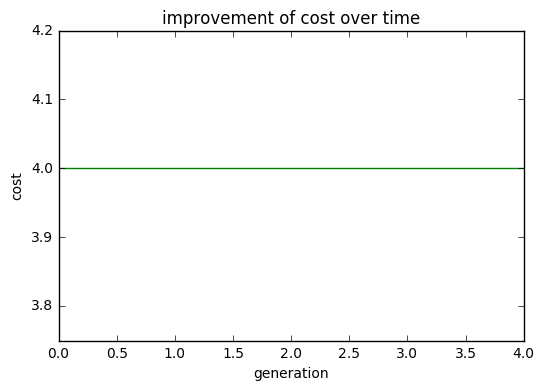

In [105]:
%matplotlib inline
from matplotlib import pyplot as plt

plt.plot(range(len(bestDist)), bestDist, color="green")
plt.xlabel("generation")
plt.ylabel("cost")
plt.title("improvement of cost over time")

#### Music Feature Selection

In [24]:
#Your Code

## Clustering und automatische Playlistgenerierung
Implementieren Sie ein hierarchisches Clustering aller Subsequenzen in _subFeaturesTrain1.csv_. Diese _.csv_-Datei enthält nur die im vorigen Schritt ermittelten wichtigsten Merkmale. Das hierarchische Clustering ist in einem Dendrogram der Art wie in der unten gegebenen Abbildung zu visualisieren.

Die gefundenen Cluster sind mit den zugehörigen Musiktiteln in der Konsole auszugeben. 

**Aufgaben:**

1. Optimieren Sie die Parameter

    1. metric (Ähnlichkeitsmaß)
    2. linkage method
    3. Clusteranzahl
    
2. Für welche Parameterkonstellation erlangen Sie das für Sie subjektiv betrachtet günstigste Ergebnis?
3. Überlegen Sie sich Ansätze um diese Art der Musikgruppierung zu verbessern?

![Abbildung Music Clustering](https://www.hdm-stuttgart.de/~maucher/ipnotebooks/DataMining//Bilder/playlistCluster.png "Music Clustering")

In [92]:
from sklearn.cluster import FeatureAgglomeration

agglo = FeatureAgglomeration()

agglo.fit()


TypeError: fit() takes at least 2 arguments (1 given)